In [1]:
import tensorflow as ts
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import Callback

import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

def custom_loss(y_true, y_pred,gamma, beta, e, x0, T,alpha,t):
    """
    Calculates the L2 norm of the difference between y_pred and a constant value, plus
    a scaled sum of y_pred, for each example in the batch. Returns the average L2 norm
    over all examples.

    Args:
    y_true: tensor of true labels
    y_pred: tensor of predicted labels

    Returns:
    A tensor representing the mean L2 norm over all examples.
    """
    
     # calculate the difference y_pred[i] - c * sum(y_pred)
    n = K.int_shape(y_pred)[1]
    hs = 1.0 / n
    H1 = alpha*e*(3*gamma-2*x0)*(T-t)/3
    intu_T = hs*K.sum(y_pred, axis=1, keepdims=True)
    intu_t = hs*K.cumsum(y_pred, axis=1)
    H2 = -2*alpha*e*hs*(K.sum(intu_t, axis=1,keepdims=True)-K.cumsum(intu_t, axis=1))/3
    H3 = e*(1-alpha)*(3*gamma-2*x0-2*intu_T)/3
    diff = H1+H2+H3-beta*y_pred
    
    # calculate the L2 norm for each example
    norma = K.sqrt(K.sum(K.square(diff), axis=1))/n
    
    # return the average L2 norm over all training examples
    return K.mean(norma)



class SavePredictions(Callback):
    def __init__(self, x_val):
        self.x_val = x_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Faz as previsões no conjunto de validação
        y_pred = self.model.predict(self.x_val)
        
        # Salva as previsões em uma lista
        self.predictions.append(y_pred)
        
        # Salva as previsões em um arquivo a cada 5 épocas
        if epoch % 10 == 0:
            np.save('solutions/din_1_fun_2_epoch{}.npy'.format(10000+epoch), y_pred)

def trimf(x,a,b,c):
    rs = np.nan
    if x<a or x>c:
        rs = 0
    elif x>=a and x<=b:
        rs = (x-a)/(b-a)
    elif x>b and x<=c:
        rs = (c-x)/(c-b)
    return rs

def dinamica(u,x,t,T):
    tv = np.space(0,T,len(u))
    hs = tv[1]
    aux = np.interp(t,tv,hs*np.cumsum(u))
    return x+aux,x-aux

def construir_sol(t,z,u,fuz):
    rs = np.zeros(shape=(len(z),len(t)))
    u = t[1]*np.cumsum(u)
    for i,vt in enumerate(t):
        for j,vz in enumerate(z):
            rs[j,i] = trimf(vz-u[i],fuz[0],fuz[1],fuz[2])
    return rs

def construir_sol_2(u,fuz):
    hs = 1/len(u)
    # w = np.exp(hs*np.cumsum(u))
    w = hs*np.cumsum(u)
    xi = np.linspace(fuz[0],fuz[1],100)
    xs = np.linspace(fuz[1],fuz[2],100)
    S = np.zeros(shape=(100,len(u)))
    I = np.zeros(shape=(100,len(u)))
    for i in range(100):
        S[i,:] = xs[99-i]+w
        I[i,:] = xi[i]+w
    return I,S

def funcional(u,gamma, beta, e, x0, T,alpha):
    hs = T/len(u)
    w = hs*np.cumsum(u)
    phit = e*(e*e + 30*gamma*gamma - 30*gamma*w - 30*gamma*x0 + 10*w*w  + 20*x0*w + 10*x0*x0)/15
    Iu2 =  hs*np.sum(u*u)
    ju = 0.5*(1-alpha)*phit[-1]+0.5*alpha*hs*np.sum(phit)+0.5*beta*Iu2
    return ju

def funcional2(pert,solI,solS,u,gamma, beta, T,alpha):
    hs = T/len(u)
    pert = np.linspace(0,1,100)[1:].reshape(99,1) 
    dS = np.abs(np.diff(solS,axis=0))
    dI = np.abs(np.diff(solI,axis=0))
    auxI = pert*solI[1:,:]-gamma
    auxS = pert*solS[1:,:]-gamma
    phit = np.sum(dI*auxI**2,axis=0)+np.sum(dS*auxS**2,axis=0)
    Iu2 =  hs*np.sum(u*u)
    ju = 0.5*(1-alpha)*phit[-1]+0.5*alpha*hs*np.sum(phit)+0.5*beta*Iu2
    return ju

2023-04-28 19:55:59.971332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


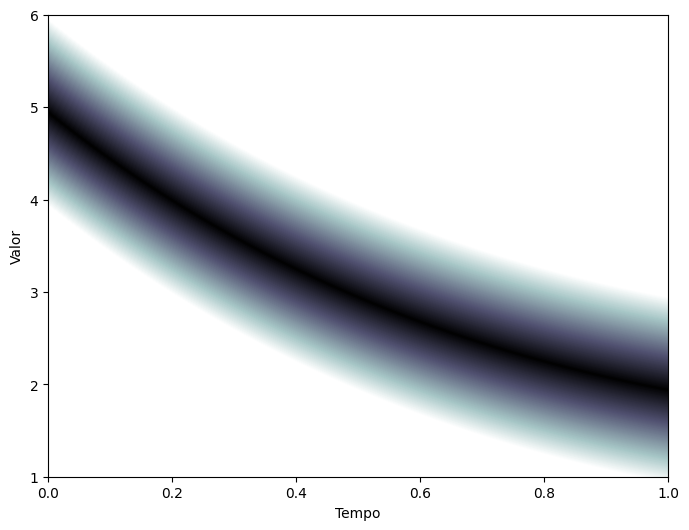

In [2]:
u = np.load("solutions/din_1_fun_2_epoch11000.npy").ravel()
t = np.linspace(0,1,len(u))
I,S = construir_sol_2(u,[4,5,6])
n = len(u)
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('bone_r')
for i in range(100):
    ax.fill_between(t, S[i,:], I[i,:], color=cmap(i/n))

ax.set_xlabel('Tempo')
ax.set_ylabel('Valor')
ax.set_xlim([0,1])
ax.set_ylim([1,6])
# mostra a figura

plt.show()

In [3]:
pert = np.linspace(0,1,100)[1:].reshape(99,1) 
funcional2(pert,I,S,u,0.0, 1/4, 1,0.5)

3.7880763739726864

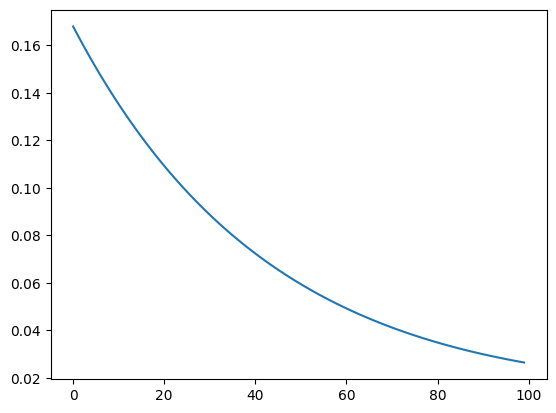

In [106]:
gamma = 0.0
beta = 1/4.0
e = 1.0
x0 = 5.0
T = 1.0
alpha = 0.5

u = np.load("solutions/din_1_fun_2_epoch11000.npy").ravel()
t = np.linspace(0,1,len(u))
solI,solS = construir_sol_2(u,[x0-e,x0,x0+e])

hs = T/len(u)

pert = np.linspace(0,1,100)[1:].reshape(99,1) 
dS = np.abs(np.diff(solS,axis=0))
dI = np.abs(np.diff(solI,axis=0))
auxI = pert*dI*solI[1:,:]-gamma*dI
auxS = pert*dS*solS[1:,:]-gamma*dS
phit = np.sum(auxI**2,axis=0)+np.sum(auxS**2,axis=0)
Iu2 =  hs*np.sum(u*u)
plt.plot(phit)